# VNS:

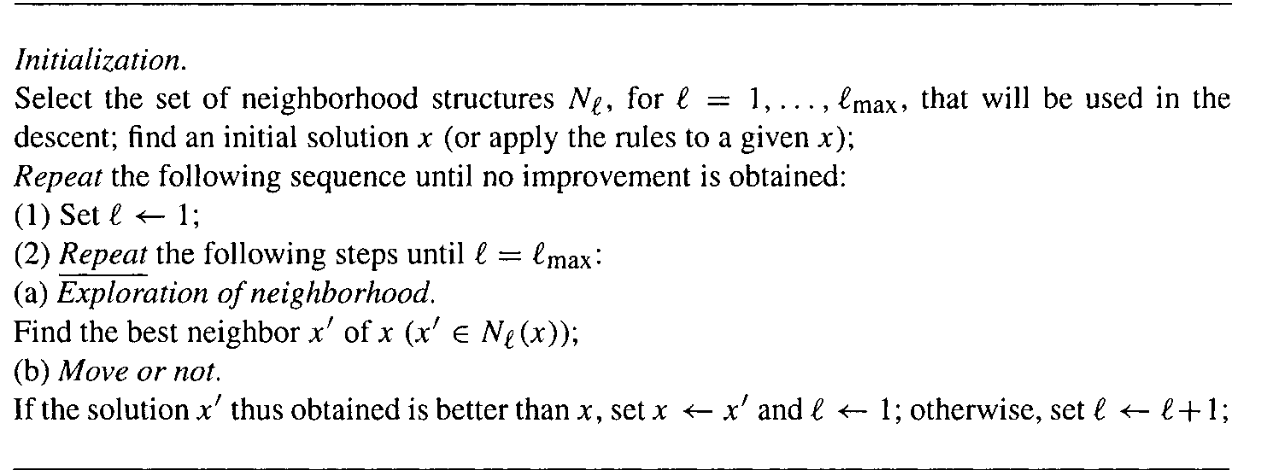

## dummy data

In [ ]:
import numpy as np
import random

# Function to calculate the total distance of a tour
def calculate_distance(tour, distance_matrix):
    distance = 0
    n = len(tour)

    for i in range(n - 1):
        distance += distance_matrix[tour[i]][tour[i + 1]]


    distance += distance_matrix[tour[-1]][tour[0]]  # Return to the starting city
    return distance

# Function to generate a random initial solution
def generate_initial_solution(num_cities):
    return list(range(num_cities))

# Function to apply 2-opt local search
def apply_2_opt(tour, i, j):
    new_tour = tour[:i] + tour[i:j + 1][::-1] + tour[j + 1:]
    return new_tour

# Function to apply random swap local search
def apply_random_swap(tour, i, j):
    # i, j = random.sample(range(len(tour)), 2)
    new_tour = tour.copy()
    new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
    return new_tour

# Shaking to perturb the initial solution
def shaking(initial_solution, distance_matrix, neighborhood_structure):
    i, j = random.sample(range(len(initial_solution)), 2)
    i, j = min(i, j), max(i, j)
    perturbed_solution = neighborhood_structure(initial_solution, i, j)
    return perturbed_solution

# Local search to improve a solution using a given neighborhood structure
def local_search(initial_solution, distance_matrix, neighborhood_structure):
    current_solution = initial_solution
    improved = True

    while improved:
        improved = False
        for i in range(len(current_solution) - 1):
            for j in range(i + 1, len(current_solution)):
                neighbor_solution = neighborhood_structure(current_solution, i, j)
                neighbor_distance = calculate_distance(neighbor_solution, distance_matrix)
                current_distance = calculate_distance(current_solution, distance_matrix)

                if neighbor_distance < current_distance:
                    current_solution = neighbor_solution
                    improved = True
                    break  # Break out of the inner loop as soon as an improvement is found

            if improved:
                break  # Break out of the outer loop if an improvement is found

    return current_solution


# Variable Neighborhood Search (VNS) for TSP
def vns_tsp(distance_matrix, num_iterations, neighborhood_structures):
    num_cities = len(distance_matrix)
    current_solution = generate_initial_solution(num_cities)

    k = 0  # Initialize the index for the current neighborhood

    for _ in range(num_iterations):
        # Shaking to perturb the initial solution
        perturbed_solution = shaking(current_solution, distance_matrix, neighborhood_structures[k])

        # Local search with the perturbed solution
        local_search_solution = local_search(perturbed_solution, distance_matrix, neighborhood_structures[k])

        # Compare the local search solution with the initial solution
        if calculate_distance(local_search_solution, distance_matrix) < calculate_distance(current_solution, distance_matrix):
            current_solution = local_search_solution
        else:
            k = (k + 1) % len(neighborhood_structures)  # Increment the index and wrap around if needed

    return current_solution

# Example usage:
# Define a distance matrix (replace this with your actual data)
distance_matrix = np.array([[0, 10, 15, 20],
                            [10, 0, 35, 25],
                            [15, 35, 0, 30],
                            [20, 25, 30, 0]])

num_iterations = 100

# Define the set of neighborhood structures in order
neighborhood_structures = [apply_2_opt, apply_random_swap]

final_solution = vns_tsp(distance_matrix, num_iterations, neighborhood_structures)
final_distance = calculate_distance(final_solution, distance_matrix)

print("Final TSP Tour:", final_solution)
print("Total Distance:", final_distance)


Final TSP Tour: [2, 0, 1, 3]
Total Distance: 80


## berlin52

In [ ]:
import time

import numpy as np
import random

def calculate_distance(tour, distance_matrix):
    distance = 0
    n = len(tour)

    for i in range(n - 1):
        distance += distance_matrix[tour[i]][tour[i + 1]]

    distance += distance_matrix[tour[-1]][tour[0]]
    return distance

def generate_initial_solution(num_cities):
    return list(range(num_cities))

def generate_initial_solution_nearest_neighbor(distance_matrix):
    num_cities = len(distance_matrix)
    unvisited_cities = set(range(1, num_cities))
    current_city = random.choice(list(unvisited_cities))
    initial_solution = [0]

    while unvisited_cities:
        nearest_neighbor = min(unvisited_cities, key=lambda city: distance_matrix[current_city][city])
        initial_solution.append(nearest_neighbor)
        unvisited_cities.remove(nearest_neighbor)
        current_city = nearest_neighbor

    return initial_solution


def apply_2_opt(tour, i, j):
    new_tour = tour[:i] + tour[i:j + 1][::-1] + tour[j + 1:]
    return new_tour

def apply_random_swap(tour, i, j):
    new_tour = tour.copy()
    new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
    return new_tour

def shaking(initial_solution, distance_matrix, neighborhood_structure):
    i, j = random.sample(range(len(initial_solution)), 2)
    i, j = min(i, j), max(i, j)
    perturbed_solution = neighborhood_structure(initial_solution, i, j)
    return perturbed_solution

def local_search(initial_solution, distance_matrix, neighborhood_structure):
    current_solution = initial_solution
    improved = True

    while improved:
        improved = False
        for i in range(len(current_solution) - 1):
            for j in range(i + 1, len(current_solution)):
                neighbor_solution = neighborhood_structure(current_solution, i, j)
                neighbor_distance = calculate_distance(neighbor_solution, distance_matrix)
                current_distance = calculate_distance(current_solution, distance_matrix)

                if neighbor_distance < current_distance:
                    current_solution = neighbor_solution
                    improved = True
                    break

            if improved:
                break

    return current_solution

def read_tsplib_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    num_cities_index = [i for i, line in enumerate(lines) if line.startswith("DIMENSION")][0]
    num_cities = int(lines[num_cities_index].split(":")[1])

    coord_section_index = [i for i, line in enumerate(lines) if line.startswith("NODE_COORD_SECTION")][0] + 1

    node_coords = [list(map(float, lines[i].split()[1:])) for i in range(coord_section_index, coord_section_index + num_cities)]

    return num_cities, np.array(node_coords)

def vns_tsp(distance_matrix, num_iterations, neighborhood_structures):
    num_cities = len(distance_matrix)
    current_solution = generate_initial_solution(num_cities)

    k = 0

    for _ in range(num_iterations):
        perturbed_solution = shaking(current_solution, distance_matrix, neighborhood_structures[k])
        local_search_solution = local_search(perturbed_solution, distance_matrix, neighborhood_structures[k])

        if calculate_distance(local_search_solution, distance_matrix) < calculate_distance(current_solution, distance_matrix):
            current_solution = local_search_solution
        else:
            k = (k + 1) % len(neighborhood_structures)

    return current_solution

# Example usage:
file_path = '/content/drive/MyDrive/recuit_simule/berlin52.tsp'
num_cities, node_coords = read_tsplib_file(file_path)

distance_matrix = np.zeros((num_cities, num_cities))
for i in range(num_cities):
    for j in range(num_cities):
        distance_matrix[i, j] = np.linalg.norm(node_coords[i] - node_coords[j])

num_iterations = 100
neighborhood_structures = [apply_2_opt, apply_random_swap]

best_route=[]
best_route_distance=[]
convergence_time=[]

for _ in range(10):
    start_time = time.time()

    final_solution = vns_tsp(distance_matrix, num_iterations, neighborhood_structures)
    final_distance = calculate_distance(final_solution, distance_matrix)

    end_time = time.time()

    execution_time = end_time - start_time

    best_route.append(final_solution)
    best_route_distance.append(final_distance)
    execution_time = end_time - start_time
    convergence_time.append(execution_time)


best_distance = min(best_route_distance)
worst_distance = max(best_route_distance)
average_distance = (best_distance+worst_distance)/2
average_time = sum(convergence_time) / len(convergence_time)

print("Best Distance:", best_distance)
print("Worst Distance:", worst_distance)
print("Average Distance:", average_distance)
print("Average Execution Time:", average_time, "seconds")


Best Distance: 7544.365901904086
Worst Distance: 7903.770228771101
Average Distance: 7724.068065337593
Average Execution Time: 42.835890316963194 seconds


## berlin52 with different configs

In [ ]:
import time
import numpy as np
import random
import csv

def calculate_distance(tour, distance_matrix):
    distance = 0
    n = len(tour)

    for i in range(n - 1):
        distance += distance_matrix[tour[i]][tour[i + 1]]

    distance += distance_matrix[tour[-1]][tour[0]]  # Return to the starting city
    return distance

def generate_initial_solution(num_cities):
    return list(range(num_cities))

# Nearest Neighbor Constructive Method for Initial Solution
def generate_initial_solution_nearest_neighbor(distance_matrix):
    num_cities = len(distance_matrix)
    unvisited_cities = set(range(1, num_cities))
    current_city = random.choice(list(unvisited_cities))
    initial_solution = [0]  # Start with the first city (index 0)

    while unvisited_cities:
        nearest_neighbor = min(unvisited_cities, key=lambda city: distance_matrix[current_city][city])
        initial_solution.append(nearest_neighbor)
        unvisited_cities.remove(nearest_neighbor)
        current_city = nearest_neighbor

    return initial_solution

def apply_2_opt(tour, i, j):
    new_tour = tour[:i] + tour[i:j + 1][::-1] + tour[j + 1:]
    return new_tour

def apply_random_swap(tour, i, j):
    new_tour = tour.copy()
    new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
    return new_tour

def apply_third_neighborhood(tour, i, j):
    # For example, you can swap every second pair of cities in the tour
    new_tour = tour.copy()
    for k in range(i, j, 2):
        if k + 1 < len(new_tour):
            new_tour[k], new_tour[k + 1] = new_tour[k + 1], new_tour[k]
    return new_tour

def shaking(initial_solution, distance_matrix, neighborhood_structure):
    i, j = random.sample(range(len(initial_solution)), 2)
    i, j = min(i, j), max(i, j)
    perturbed_solution = neighborhood_structure(initial_solution, i, j)
    return perturbed_solution

def local_search(initial_solution, distance_matrix, neighborhood_structure):
    current_solution = initial_solution
    improved = True

    while improved:
        improved = False
        for i in range(len(current_solution) - 1):
            for j in range(i + 1, len(current_solution)):
                neighbor_solution = neighborhood_structure(current_solution, i, j)
                neighbor_distance = calculate_distance(neighbor_solution, distance_matrix)
                current_distance = calculate_distance(current_solution, distance_matrix)

                if neighbor_distance < current_distance:
                    current_solution = neighbor_solution
                    improved = True
                    break

            if improved:
                break

    return current_solution

def read_tsplib_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    num_cities_index = [i for i, line in enumerate(lines) if line.startswith("DIMENSION")][0]
    num_cities = int(lines[num_cities_index].split(":")[1])

    coord_section_index = [i for i, line in enumerate(lines) if line.startswith("NODE_COORD_SECTION")][0] + 1

    node_coords = [list(map(float, lines[i].split()[1:])) for i in range(coord_section_index, coord_section_index + num_cities)]

    return num_cities, np.array(node_coords)

def vns_tsp(distance_matrix, num_iterations, neighborhood_structures, initial_solution_method):
    num_cities = len(distance_matrix)

    if initial_solution_method == "random":
        initial_solution = generate_initial_solution(num_cities)
    elif initial_solution_method == "constructive":
        initial_solution = generate_initial_solution_nearest_neighbor(distance_matrix)
    else:
        raise ValueError("Invalid initial solution method")

    current_solution = initial_solution

    k = 0

    for _ in range(num_iterations):
        perturbed_solution = shaking(current_solution, distance_matrix, neighborhood_structures[k])
        local_search_solution = local_search(perturbed_solution, distance_matrix, neighborhood_structures[k])

        if calculate_distance(local_search_solution, distance_matrix) < calculate_distance(current_solution, distance_matrix):
            current_solution = local_search_solution
        else:
            k = (k + 1) % len(neighborhood_structures)

    return current_solution

def write_results_to_csv(filename, data):
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(data)

def experiment(num_iterations_list, neighborhoods_list, initial_solution_methods):
    results = []

    for num_iterations in num_iterations_list:
        for neighborhoods in neighborhoods_list:
            for initial_solution_method in initial_solution_methods:
                best_route = []
                best_route_distance = []
                convergence_time = []

                for _ in range(10):

                    start_time = time.time()


                    final_solution = vns_tsp(distance_matrix, num_iterations, neighborhoods, initial_solution_method)
                    final_distance = calculate_distance(final_solution, distance_matrix)

                    end_time = time.time()

                    execution_time = end_time - start_time

                    best_route.append(final_solution)
                    best_route_distance.append(final_distance)
                    convergence_time.append(execution_time)

                best_distance = min(best_route_distance)
                worst_distance = max(best_route_distance)
                average_distance = (best_distance + worst_distance) / 2
                average_time = sum(convergence_time) / len(convergence_time)

                results.append([num_iterations, neighborhoods, initial_solution_method, best_distance, worst_distance, average_distance, average_time])

    return results

# Example usage:
file_path = '/content/drive/MyDrive/recuit_simule/berlin52.tsp'
num_cities, node_coords = read_tsplib_file(file_path)

# Create the distance matrix based on Euclidean distance
distance_matrix = np.zeros((num_cities, num_cities))
for i in range(num_cities):
    for j in range(num_cities):
        distance_matrix[i, j] = np.linalg.norm(node_coords[i] - node_coords[j])

num_iterations_list = [50, 100]
neighborhoods_list = [[apply_2_opt, apply_random_swap], [apply_2_opt, apply_random_swap, apply_third_neighborhood]]
initial_solution_methods = ["random", "constructive"]

results = experiment(num_iterations_list, neighborhoods_list, initial_solution_methods)

# Print results
for result in results:
    print(result)

# Write results to CSV file
csv_filename = 'results_vns_berlin52.csv'
write_results_to_csv(csv_filename, results)
print(f"Results written to {csv_filename}")


[50, [<function apply_2_opt at 0x7f8f1ca765f0>, <function apply_random_swap at 0x7f8f1ca760e0>], 'random', 7544.365901904088, 8021.075163982547, 7782.720532943317, 25.058728194236757]
[50, [<function apply_2_opt at 0x7f8f1ca765f0>, <function apply_random_swap at 0x7f8f1ca760e0>], 'constructive', 7544.365901904086, 8037.618573559081, 7790.992237731583, 21.394993019104003]
[50, [<function apply_2_opt at 0x7f8f1ca765f0>, <function apply_random_swap at 0x7f8f1ca760e0>, <function apply_third_neighborhood at 0x7f8f1ca76200>], 'random', 7544.365901904088, 8022.225231675402, 7783.295566789745, 22.286533665657043]
[50, [<function apply_2_opt at 0x7f8f1ca765f0>, <function apply_random_swap at 0x7f8f1ca760e0>, <function apply_third_neighborhood at 0x7f8f1ca76200>], 'constructive', 7677.68268289901, 8054.127685380119, 7865.905184139565, 17.931066942214965]
[100, [<function apply_2_opt at 0x7f8f1ca765f0>, <function apply_random_swap at 0x7f8f1ca760e0>], 'random', 7544.365901904086, 7777.33231127591

## ch130 with different configs

In [ ]:
import time
import numpy as np
import random
import csv
from tqdm import tqdm


def calculate_distance(tour, distance_matrix):
    distance = 0
    n = len(tour)

    for i in range(n - 1):
        distance += distance_matrix[tour[i]][tour[i + 1]]

    distance += distance_matrix[tour[-1]][tour[0]]
    return distance

def generate_initial_solution(num_cities):
    return list(range(num_cities))

def generate_initial_solution_nearest_neighbor(distance_matrix):
    num_cities = len(distance_matrix)
    unvisited_cities = set(range(1, num_cities))
    current_city = random.choice(list(unvisited_cities))
    initial_solution = [0]

    while unvisited_cities:
        nearest_neighbor = min(unvisited_cities, key=lambda city: distance_matrix[current_city][city])
        initial_solution.append(nearest_neighbor)
        unvisited_cities.remove(nearest_neighbor)
        current_city = nearest_neighbor

    return initial_solution

def apply_2_opt(tour, i, j):
    new_tour = tour[:i] + tour[i:j + 1][::-1] + tour[j + 1:]
    return new_tour

def apply_random_swap(tour, i, j):
    new_tour = tour.copy()
    new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
    return new_tour

def apply_third_neighborhood(tour, i, j):
    new_tour = tour.copy()
    for k in range(i, j, 2):
        if k + 1 < len(new_tour):
            new_tour[k], new_tour[k + 1] = new_tour[k + 1], new_tour[k]
    return new_tour

def shaking(initial_solution, distance_matrix, neighborhood_structure):
    i, j = random.sample(range(len(initial_solution)), 2)
    i, j = min(i, j), max(i, j)
    perturbed_solution = neighborhood_structure(initial_solution, i, j)
    return perturbed_solution

def local_search(initial_solution, distance_matrix, neighborhood_structure):
    current_solution = initial_solution
    improved = True

    while improved:
        improved = False
        for i in range(len(current_solution) - 1):
            for j in range(i + 1, len(current_solution)):
                neighbor_solution = neighborhood_structure(current_solution, i, j)
                neighbor_distance = calculate_distance(neighbor_solution, distance_matrix)
                current_distance = calculate_distance(current_solution, distance_matrix)

                if neighbor_distance < current_distance:
                    current_solution = neighbor_solution
                    improved = True
                    break

            if improved:
                break

    return current_solution

def read_tsplib_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    num_cities_index = [i for i, line in enumerate(lines) if line.startswith("DIMENSION")][0]
    num_cities = int(lines[num_cities_index].split(":")[1])

    coord_section_index = [i for i, line in enumerate(lines) if line.startswith("NODE_COORD_SECTION")][0] + 1

    node_coords = [list(map(float, lines[i].split()[1:])) for i in range(coord_section_index, coord_section_index + num_cities)]

    return num_cities, np.array(node_coords)

def vns_tsp(distance_matrix, num_iterations, neighborhood_structures, initial_solution_method):
    num_cities = len(distance_matrix)

    if initial_solution_method == "random":
        initial_solution = generate_initial_solution(num_cities)
    elif initial_solution_method == "constructive":
        initial_solution = generate_initial_solution_nearest_neighbor(distance_matrix)
    else:
        raise ValueError("Invalid initial solution method")

    current_solution = initial_solution

    k = 0

    for _ in tqdm(range(num_iterations), desc=f"{num_iterations}", unit="iteration"):
        perturbed_solution = shaking(current_solution, distance_matrix, neighborhood_structures[k])
        local_search_solution = local_search(perturbed_solution, distance_matrix, neighborhood_structures[k])

        if calculate_distance(local_search_solution, distance_matrix) < calculate_distance(current_solution, distance_matrix):
            current_solution = local_search_solution
        else:
            k = (k + 1) % len(neighborhood_structures)

    return current_solution

def write_results_to_csv(filename, data):
    with open(filename, 'w', newline='') as file:
        fieldnames = ['num_iterations', 'neighborhoods', 'initial_solution_method', 'best_distance', 'worst_distance', 'average_distance', 'average_time']
        # writer = csv.writer(file)
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(data)


def experiment(num_iterations_list, neighborhoods_list, initial_solution_methods):
    results = []

    for num_iterations in num_iterations_list:
        for neighborhoods in neighborhoods_list:
            for initial_solution_method in initial_solution_methods:
                best_route = []
                best_route_distance = []
                convergence_time = []
                print(neighborhoods,num_iterations, initial_solution_method)
                for _ in range(10):

                    start_time = time.time()

                    final_solution = vns_tsp(distance_matrix, num_iterations, neighborhoods, initial_solution_method)
                    final_distance = calculate_distance(final_solution, distance_matrix)

                    end_time = time.time()

                    execution_time = end_time - start_time

                    best_route.append(final_solution)
                    best_route_distance.append(final_distance)
                    convergence_time.append(execution_time)
                    print('iteration ',_)
                print('----------------------')

                # Calculate average distance and time
                best_distance = min(best_route_distance)
                worst_distance = max(best_route_distance)
                average_distance = (best_distance + worst_distance) / 2
                average_time = sum(convergence_time) / len(convergence_time)

                results.append([num_iterations, neighborhoods, initial_solution_method, best_distance, worst_distance, average_distance, average_time])

    return results

# Example usage:
file_path = '/content/drive/MyDrive/recuit_simule/ch130.tsp'
num_cities, node_coords = read_tsplib_file(file_path)

distance_matrix = np.zeros((num_cities, num_cities))
for i in range(num_cities):
    for j in range(num_cities):
        distance_matrix[i, j] = np.linalg.norm(node_coords[i] - node_coords[j])

num_iterations_list = [50, 80]
neighborhoods_list = [ [apply_2_opt, apply_random_swap]]
initial_solution_methods = ["constructive"]

results = experiment(num_iterations_list, neighborhoods_list, initial_solution_methods)

# Print results
for result in results:
    print(result)

# Write results to CSV file
csv_filename = '/content/drive/MyDrive/recuit_simule/results_vns_ch130.csv'
write_results_to_csv(csv_filename, results)
print(f"Results written to {csv_filename}")


# Recuit simule:

## berlin52

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.0 MB/s eta 0:00:00
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.2.1:
      Successfully uninstalled networkx-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
Best Route Distances: [8937.0, 8848.0, 8931.0, 8965.0, 8992.0, 8903.0, 8914.0, 8971.0, 8917.0, 8999.0]
Best Distance: 8848.0
Worst Distance: 8999.0
Convergence Times: [30.069637298583984, 25.2056255340

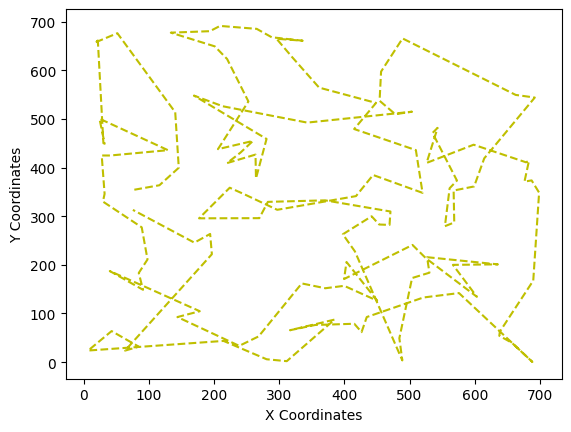

In [ ]:
!pip install tsplib95
import tsplib95
import random
import math
import time
import copy
import matplotlib.pyplot as plt

data = tsplib95.load('/content/drive/MyDrive/recuit_simule/ch130.tsp')
cities = list(data.get_nodes())

def annealing(initial_state, target_distance=8000):
    # a changer
    initial_temp = 5000
    # a changer
    alpha = 0.99
    current_temp = initial_temp

    solution = initial_state
    same_solution = 0
    same_cost_diff = 0

    current_distance = 1 / get_cost(solution)

    # a changer
    max_iterations = 100000  # Adjust as needed
    iterations = 0

    while current_distance > target_distance and iterations < max_iterations:
        neighbor = get_neighbors(solution)

        cost_diff = get_cost(neighbor) - get_cost(solution)

        if cost_diff > 0:
            solution = neighbor
            same_solution = 0
            same_cost_diff = 0
        elif cost_diff == 0:
            solution = neighbor
            same_solution = 0
            same_cost_diff += 1
        else:
            if random.uniform(0, 1) <= math.exp(float(cost_diff) / float(current_temp)):
                solution = neighbor
                same_solution = 0
                same_cost_diff = 0
            else:
                same_solution += 1
                same_cost_diff += 1

        current_temp = current_temp * alpha

        current_distance = 1 / get_cost(solution)
        # print("Current Distance:", current_distance)
        # print("Target Distance:", target_distance)
        # print("Current Temp:", current_temp)

        iterations += 1

    # print("Final Distance:", 1 / get_cost(solution))

    return solution, 1 / get_cost(solution)


def get_cost(state):
    distance = 0

    for i in range(len(state)):
        from_city = state[i]
        to_city = None
        if i + 1 < len(state):
            to_city = state[i + 1]
        else:
            to_city = state[0]
        distance += data.get_weight(from_city, to_city)
    fitness = 1 / float(distance)
    return fitness


def get_neighbors(state):
    neighbor = copy.deepcopy(state)

    func = random.choice([0, 1, 2, 3])
    if func == 0:
        inverse(neighbor)
    elif func == 1:
        insert(neighbor)
    elif func == 2:
        swap(neighbor)
    else:
        swap_routes(neighbor)

    return neighbor


def inverse(state):
    node_one = random.choice(state)
    new_list = list(filter(lambda city: city != node_one, state))
    node_two = random.choice(new_list)
    state[min(node_one, node_two):max(node_one, node_two)] = state[min(node_one, node_two):max(node_one, node_two)][::-1]
    return state


def insert(state):
    node_j = random.choice(state)
    state.remove(node_j)
    node_i = random.choice(state)
    index = state.index(node_i)
    state.insert(index, node_j)
    return state


def swap(state):
    pos_one = random.choice(range(len(state)))
    pos_two = random.choice(range(len(state)))
    state[pos_one], state[pos_two] = state[pos_two], state[pos_one]
    return state


def swap_routes(state):
    subroute_a = random.choice(range(len(state)))
    subroute_b = random.choice(range(len(state)))
    subroute = state[min(subroute_a, subroute_b):max(subroute_a, subroute_b)]
    del state[min(subroute_a, subroute_b):max(subroute_a, subroute_b)]
    insert_pos = random.choice(range(len(state)))
    for i in subroute:
        state.insert(insert_pos, i)
    return state


best_route_distance = []
best_route = []
convergence_time = []

for i in range(10):
    start = time.time()
    route, route_distance = annealing(cities, target_distance=9000)
    time_elapsed = time.time() - start
    best_route_distance.append(route_distance)
    best_route.append(route)
    convergence_time.append(time_elapsed)

    xs = [data.node_coords[i][0] for i in route]
    ys = [data.node_coords[i][1] for i in route]

    plt.clf()
    plt.plot(xs, ys, 'y--')
    plt.xlabel('X Coordinates')
    plt.ylabel('Y Coordinates')

print("Best Route Distances:", best_route_distance)
print("Best Distance:", min(best_route_distance))
print("Worst Distance:", max(best_route_distance))
print("Convergence Times:", convergence_time)
print("avg Time:", sum(convergence_time) / len(convergence_time))


## ch130

Best Route Distances: [8921.0, 8857.0, 8991.0, 8915.0, 8973.0, 8991.0, 8964.0, 8973.0, 8971.0, 8937.0]
Convergence Times: [41.001676082611084, 41.23435878753662, 38.41237473487854, 35.971821546554565, 34.76617980003357, 52.87366557121277, 27.704190731048584, 47.950968742370605, 41.5512490272522, 38.132535219192505]


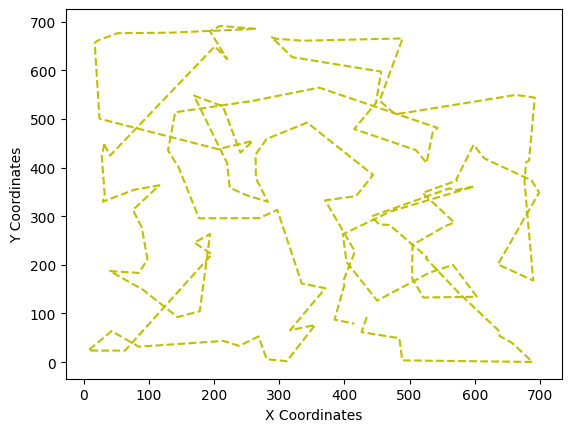

In [ ]:
import tsplib95
import random
import math
import time
import copy
import matplotlib.pyplot as plt

data = tsplib95.load('/content/drive/MyDrive/recuit_simule/ch130.tsp')
cities = list(data.get_nodes())

def annealing(initial_state, target_distance=8000):
    # a changer
    initial_temp = 5000
    # a changer
    alpha = 0.99
    current_temp = initial_temp

    solution = initial_state
    same_solution = 0
    same_cost_diff = 0

    current_distance = 1 / get_cost(solution)

    # a changer
    max_iterations = 100000  # Adjust as needed
    iterations = 0

    while current_distance > target_distance and iterations < max_iterations:
        neighbor = get_neighbors(solution)

        cost_diff = get_cost(neighbor) - get_cost(solution)

        if cost_diff > 0:
            solution = neighbor
            same_solution = 0
            same_cost_diff = 0
        elif cost_diff == 0:
            solution = neighbor
            same_solution = 0
            same_cost_diff += 1
        else:
            if random.uniform(0, 1) <= math.exp(float(cost_diff) / float(current_temp)):
                solution = neighbor
                same_solution = 0
                same_cost_diff = 0
            else:
                same_solution += 1
                same_cost_diff += 1

        current_temp = current_temp * alpha

        current_distance = 1 / get_cost(solution)
        # print("Current Distance:", current_distance)
        # print("Target Distance:", target_distance)
        # print("Current Temp:", current_temp)

        iterations += 1

    # print("Final Distance:", 1 / get_cost(solution))

    return solution, 1 / get_cost(solution)


def get_cost(state):
    distance = 0

    for i in range(len(state)):
        from_city = state[i]
        to_city = None
        if i + 1 < len(state):
            to_city = state[i + 1]
        else:
            to_city = state[0]
        distance += data.get_weight(from_city, to_city)
    fitness = 1 / float(distance)
    return fitness


def get_neighbors(state):
    neighbor = copy.deepcopy(state)

    func = random.choice([0, 1, 2, 3])
    if func == 0:
        inverse(neighbor)
    elif func == 1:
        insert(neighbor)
    elif func == 2:
        swap(neighbor)
    else:
        swap_routes(neighbor)

    return neighbor


def inverse(state):
    node_one = random.choice(state)
    new_list = list(filter(lambda city: city != node_one, state))
    node_two = random.choice(new_list)
    state[min(node_one, node_two):max(node_one, node_two)] = state[min(node_one, node_two):max(node_one, node_two)][::-1]
    return state


def insert(state):
    node_j = random.choice(state)
    state.remove(node_j)
    node_i = random.choice(state)
    index = state.index(node_i)
    state.insert(index, node_j)
    return state


def swap(state):
    pos_one = random.choice(range(len(state)))
    pos_two = random.choice(range(len(state)))
    state[pos_one], state[pos_two] = state[pos_two], state[pos_one]
    return state


def swap_routes(state):
    subroute_a = random.choice(range(len(state)))
    subroute_b = random.choice(range(len(state)))
    subroute = state[min(subroute_a, subroute_b):max(subroute_a, subroute_b)]
    del state[min(subroute_a, subroute_b):max(subroute_a, subroute_b)]
    insert_pos = random.choice(range(len(state)))
    for i in subroute:
        state.insert(insert_pos, i)
    return state


best_route_distance = []
best_route = []
convergence_time = []

for i in range(10):
    start = time.time()
    route, route_distance = annealing(cities, target_distance=9000)
    time_elapsed = time.time() - start
    best_route_distance.append(route_distance)
    best_route.append(route)
    convergence_time.append(time_elapsed)

    xs = [data.node_coords[i][0] for i in route]
    ys = [data.node_coords[i][1] for i in route]

    plt.clf()
    plt.plot(xs, ys, 'y--')
    plt.xlabel('X Coordinates')
    plt.ylabel('Y Coordinates')

print("Best Route Distances:", best_route_distance)
print("Best Distance:", min(best_route_distance))
print("Worst Distance:", max(best_route_distance))
print("Convergence Times:", convergence_time)
print("avg Time:", sum(convergence_time) / len(convergence_time))


## berlin52 with different configs

In [ ]:
import tsplib95
import random
import math
import time
import copy
import matplotlib.pyplot as plt
import csv

data = tsplib95.load('/content/drive/MyDrive/recuit_simule/berlin52.tsp')
cities = list(data.get_nodes())

def annealing(initial_state, alpha, initial_temp, max_iterations, target_distance=8000):
    current_temp = initial_temp

    solution = initial_state
    same_solution = 0
    same_cost_diff = 0

    current_distance = 1 / get_cost(solution)

    iterations = 0

    while current_distance > target_distance and iterations < max_iterations:
        neighbor = get_neighbors(solution)

        cost_diff = get_cost(neighbor) - get_cost(solution)

        if cost_diff > 0:
            solution = neighbor
            same_solution = 0
            same_cost_diff = 0
        elif cost_diff == 0:
            solution = neighbor
            same_solution = 0
            same_cost_diff += 1
        else:
            if random.uniform(0, 1) <= math.exp(float(cost_diff) / float(current_temp)):
                solution = neighbor
                same_solution = 0
                same_cost_diff = 0
            else:
                same_solution += 1
                same_cost_diff += 1

        current_temp = current_temp * alpha

        current_distance = 1 / get_cost(solution)
        iterations += 1

    return solution, 1 / get_cost(solution)

def get_cost(state):
    distance = 0

    for i in range(len(state)):
        from_city = state[i]
        to_city = None
        if i + 1 < len(state):
            to_city = state[i + 1]
        else:
            to_city = state[0]
        distance += data.get_weight(from_city, to_city)
    fitness = 1 / float(distance)
    return fitness

def get_neighbors(state):
    neighbor = copy.deepcopy(state)

    func = random.choice([0, 1, 2, 3])
    if func == 0:
        inverse(neighbor)
    elif func == 1:
        insert(neighbor)
    elif func == 2:
        swap(neighbor)
    else:
        swap_routes(neighbor)

    return neighbor

def inverse(state):
    node_one = random.choice(state)
    new_list = list(filter(lambda city: city != node_one, state))
    node_two = random.choice(new_list)
    state[min(node_one, node_two):max(node_one, node_two)] = state[min(node_one, node_two):max(node_one, node_two)][::-1]
    return state

def insert(state):
    node_j = random.choice(state)
    state.remove(node_j)
    node_i = random.choice(state)
    index = state.index(node_i)
    state.insert(index, node_j)
    return state

def swap(state):
    pos_one = random.choice(range(len(state)))
    pos_two = random.choice(range(len(state)))
    state[pos_one], state[pos_two] = state[pos_two], state[pos_one]
    return state

def swap_routes(state):
    subroute_a = random.choice(range(len(state)))
    subroute_b = random.choice(range(len(state)))
    subroute = state[min(subroute_a, subroute_b):max(subroute_a, subroute_b)]
    del state[min(subroute_a, subroute_b):max(subroute_a, subroute_b)]
    insert_pos = random.choice(range(len(state)))
    for i in subroute:
        state.insert(insert_pos, i)
    return state

# Parameters to be tested
alpha_values = [0.95, 0.99]
initial_temp_values = [1000, 10000]
max_iterations_values = [10000, 100000]

# Output file
output_file_path = '/content/drive/MyDrive/recuit_simule/results_recuit_berlin52.csv'

# Perform experiments and save results to CSV
with open(output_file_path, 'w', newline='') as csvfile:
    fieldnames = ['Alpha', 'Initial Temperature', 'Max Iterations', 'Best Distance', 'Worst Distance', 'Average Time']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for alpha in alpha_values:
        for initial_temp in initial_temp_values:
            for max_iterations in max_iterations_values:
                best_route_distance = []
                convergence_time = []

                for _ in range(10):
                    start = time.time()
                    route, route_distance = annealing(cities, alpha, initial_temp, max_iterations, target_distance=9000)
                    time_elapsed = time.time() - start
                    best_route_distance.append(route_distance)
                    convergence_time.append(time_elapsed)

                writer.writerow({
                    'Alpha': alpha,
                    'Initial Temperature': initial_temp,
                    'Max Iterations': max_iterations,
                    'Best Distance': min(best_route_distance),
                    'Worst Distance': max(best_route_distance),
                    'Average Time': sum(convergence_time) / len(convergence_time)
                })

print("Experiments completed. Results saved to:", output_file_path)


Experiments completed. Results saved to: /content/drive/MyDrive/recuit_simule/results_recuit_berlin52.csv


## ch130 with different configs

In [ ]:
import tsplib95
import random
import math
import time
import copy
import matplotlib.pyplot as plt
import csv

data = tsplib95.load('/content/drive/MyDrive/recuit_simule/ch130.tsp')
cities = list(data.get_nodes())

def annealing(initial_state, alpha, initial_temp, max_iterations, target_distance=8000):
    current_temp = initial_temp

    solution = initial_state
    same_solution = 0
    same_cost_diff = 0

    current_distance = 1 / get_cost(solution)

    iterations = 0

    while current_distance > target_distance and iterations < max_iterations:
        neighbor = get_neighbors(solution)

        cost_diff = get_cost(neighbor) - get_cost(solution)

        if cost_diff > 0:
            solution = neighbor
            same_solution = 0
            same_cost_diff = 0
        elif cost_diff == 0:
            solution = neighbor
            same_solution = 0
            same_cost_diff += 1
        else:
            if random.uniform(0, 1) <= math.exp(float(cost_diff) / float(current_temp)):
                solution = neighbor
                same_solution = 0
                same_cost_diff = 0
            else:
                same_solution += 1
                same_cost_diff += 1

        current_temp = current_temp * alpha

        current_distance = 1 / get_cost(solution)
        iterations += 1

    return solution, 1 / get_cost(solution)

def get_cost(state):
    distance = 0

    for i in range(len(state)):
        from_city = state[i]
        to_city = None
        if i + 1 < len(state):
            to_city = state[i + 1]
        else:
            to_city = state[0]
        distance += data.get_weight(from_city, to_city)
    fitness = 1 / float(distance)
    return fitness

def get_neighbors(state):
    neighbor = copy.deepcopy(state)

    func = random.choice([0, 1, 2, 3])
    if func == 0:
        inverse(neighbor)
    elif func == 1:
        insert(neighbor)
    elif func == 2:
        swap(neighbor)
    else:
        swap_routes(neighbor)

    return neighbor

def inverse(state):
    node_one = random.choice(state)
    new_list = list(filter(lambda city: city != node_one, state))
    node_two = random.choice(new_list)
    state[min(node_one, node_two):max(node_one, node_two)] = state[min(node_one, node_two):max(node_one, node_two)][::-1]
    return state

def insert(state):
    node_j = random.choice(state)
    state.remove(node_j)
    node_i = random.choice(state)
    index = state.index(node_i)
    state.insert(index, node_j)
    return state

def swap(state):
    pos_one = random.choice(range(len(state)))
    pos_two = random.choice(range(len(state)))
    state[pos_one], state[pos_two] = state[pos_two], state[pos_one]
    return state

def swap_routes(state):
    subroute_a = random.choice(range(len(state)))
    subroute_b = random.choice(range(len(state)))
    subroute = state[min(subroute_a, subroute_b):max(subroute_a, subroute_b)]
    del state[min(subroute_a, subroute_b):max(subroute_a, subroute_b)]
    insert_pos = random.choice(range(len(state)))
    for i in subroute:
        state.insert(insert_pos, i)
    return state

# Parameters to be tested
alpha_values = [0.95, 0.99]
initial_temp_values = [1000, 10000]
max_iterations_values = [10000, 100000]

# Output file
output_file_path = '/content/drive/MyDrive/recuit_simule/results_recuit_ch130.csv'

# Perform experiments and save results to CSV
with open(output_file_path, 'w', newline='') as csvfile:
    fieldnames = ['Alpha', 'Initial Temperature', 'Max Iterations', 'Best Distance', 'Worst Distance', 'Average Time']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for alpha in alpha_values:
        for initial_temp in initial_temp_values:
            for max_iterations in max_iterations_values:
                best_route_distance = []
                convergence_time = []

                for _ in range(10):
                    start = time.time()
                    route, route_distance = annealing(cities, alpha, initial_temp, max_iterations, target_distance=9000)
                    time_elapsed = time.time() - start
                    best_route_distance.append(route_distance)
                    convergence_time.append(time_elapsed)

                writer.writerow({
                    'Alpha': alpha,
                    'Initial Temperature': initial_temp,
                    'Max Iterations': max_iterations,
                    'Best Distance': min(best_route_distance),
                    'Worst Distance': max(best_route_distance),
                    'Average Time': sum(convergence_time) / len(convergence_time)
                })

print("Experiments completed. Results saved to:", output_file_path)


Experiments completed. Results saved to: /content/drive/MyDrive/recuit_simule/results_recuit_ch130.csv
